In [1]:
%load_ext autoreload
%autoreload 2

In [7]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt

from model.mlp import MLP
from dataloader.rosen import RosenData
from uncertainty_estimator.mcdue import MCDUE
from sample_selector.eager import EagerSampleSelector
from oracle.identity import IdentityOracle


In [8]:
config = {
    'random_state': 4623457,
    'n_dim': 10,
    'n_train': 200,
    'n_test': 200,
    'n_pool': 1000,
    'layers': [128, 64, 32],
    'update_sample_size': 10,
    'al_iterations': 10
}

np.random.seed(config['random_state'])

In [9]:
def print_shapes(note, *sets):
    print(note)
    for x, y in sets:
        print("shapes:", x.shape, y.shape)

# load data
X_train, y_train, _, _, X_test, y_test, X_pool, y_pool = RosenData(
    config['n_train'], 0, config['n_test'], config['n_pool'], config['n_dim']
).dataset()

print_shapes('', (X_train, y_train), (X_test, y_test), (X_pool, y_pool))


shapes: (200, 10) (200, 1)
shapes: (200, 10) (200, 1)
shapes: (1000, 10) (1000, 1)


In [12]:
# Init neural network & tf session

tf.reset_default_graph()

model = MLP(
    ndim = config['n_dim'],
    random_state = config['random_state'],
    layers = config['layers']
)

try:
    sess.close()
except:
    pass
session_config = tf.ConfigProto()
session_config.gpu_options.allow_growth = True

init = tf.global_variables_initializer()
sess = tf.Session(config=session_config)
sess.run(init)

In [13]:
estimator = MCDUE(model)  # uncertainty estimator
oracle = IdentityOracle(y_pool)  # generate y for X rom pool
sampler = EagerSampleSelector(oracle) # sample X and y from pool by uncertainty estimations

In [14]:
model.train(sess, X_train, y_train, X_test, y_test, X_test, y_test)

rmses = [np.sqrt(mse(model.predict(sess, data=X_test), y_test))]


for al_iteration in range(1, config['al_iterations']+1):
    note = f'[{al_iteration}] BEFORE:'
    print_shapes(note, (X_train, y_train), (X_test, y_test), (X_pool, y_pool))
    
    # update pool
    uncertainties = estimator.estimate(sess, X_pool)
    X_train, y_train, X_pool = sampler.update_sets(
        X_train, y_train, X_pool, uncertainties, config['update_sample_size']
    )
    
    note = f'[{al_iteration}] AFTER:'
    print_shapes(note, (X_train, y_train), (X_test, y_test), (X_pool, y_pool))
    
    # retrain net
    model.train(sess, X_train, y_train, X_test, y_test, X_test, y_test)
    rmses.append(np.sqrt(mse(model.predict(sess, data=X_test), y_test)))

[100] RMSE train:187.605 test:192.500 val:192.500 patience:3
[200] RMSE train:183.371 test:188.157 val:188.157 patience:3
[300] RMSE train:172.383 test:176.868 val:176.868 patience:3
[400] RMSE train:149.326 test:153.179 val:153.179 patience:3
[500] RMSE train:113.887 test:116.902 val:116.902 patience:3
[600] RMSE train:79.569 test:82.290 val:82.290 patience:3
[700] RMSE train:65.705 test:69.015 val:69.015 patience:3
[800] RMSE train:64.066 test:67.756 val:67.756 patience:3
[900] RMSE train:63.895 test:67.695 val:67.695 patience:3
[1000] RMSE train:63.773 test:67.620 val:67.620 patience:3
[1100] RMSE train:63.645 test:67.533 val:67.533 patience:3
[1200] RMSE train:63.511 test:67.441 val:67.441 patience:3
[1300] RMSE train:63.371 test:67.345 val:67.345 patience:3
[1400] RMSE train:63.227 test:67.247 val:67.247 patience:3
[1500] RMSE train:63.078 test:67.145 val:67.145 patience:3
[1600] RMSE train:62.925 test:67.042 val:67.042 patience:3
[1700] RMSE train:62.769 test:66.936 val:66.936 pa

[3900] RMSE train:4.454 test:32.764 val:32.764 patience:2
[4000] RMSE train:4.292 test:32.730 val:32.730 patience:3
[4100] RMSE train:4.141 test:32.730 val:32.730 patience:2
[4200] RMSE train:3.994 test:32.685 val:32.685 patience:3
[4300] RMSE train:3.846 test:32.619 val:32.619 patience:3
[4400] RMSE train:3.702 test:32.543 val:32.543 patience:3
[4500] RMSE train:3.568 test:32.560 val:32.560 patience:2
[4600] RMSE train:3.432 test:32.511 val:32.511 patience:3
[4700] RMSE train:3.308 test:32.505 val:32.505 patience:3
[4800] RMSE train:3.188 test:32.483 val:32.483 patience:3
[4900] RMSE train:3.077 test:32.474 val:32.474 patience:3
[5000] RMSE train:2.977 test:32.477 val:32.477 patience:2
[5100] RMSE train:2.881 test:32.443 val:32.443 patience:3
[5200] RMSE train:2.789 test:32.415 val:32.415 patience:3
[5300] RMSE train:2.700 test:32.411 val:32.411 patience:3
[5400] RMSE train:2.615 test:32.405 val:32.405 patience:3
[5500] RMSE train:2.533 test:32.401 val:32.401 patience:3
[5600] RMSE tr

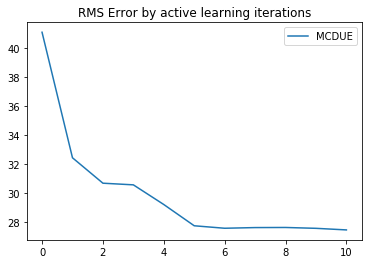

In [30]:
plt.plot(rmses, label='MCDUE')
plt.title('RMS Error by active learning iterations')
plt.legend()

In [16]:
# Show some predictions
print(model.predict(sess, data = X_test[:3]))
print(y_test[:3])

[[269.82272]
 [236.60335]
 [228.05836]]
[[269.35414184]
 [199.67728249]
 [197.7762695 ]]


In [27]:
# show some uncertainties
estimator.estimate(sess, X_pool)[:3]

array([160.86413073, 235.44600944, 191.88563576])